<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_06_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. 簡介 ===**
1. Get data
2. Create dataset and dataloader
3. Get pre-train model and customize it
4. Train model
5. Make prediction

# **=== 1. Get data ===**

In [1]:
# Import
import requests
import zipfile
import os
from pathlib import Path

# Set path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 判斷有無資料夾, 無則創立
if image_path.is_dir():
    print(f"Folder {image_path} already exists.")
else:
    print(f"Foldr {image_path} not exist, creating ...")
    image_path.mkdir(parents = True, exist_ok = True)

# 下載壓縮檔
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data ...")
    f.write(request.content)

# 解壓縮
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_f:
    print("Unziping data ...")
    zip_f.extractall(image_path)

# 刪除壓縮檔
os.remove(data_path / "pizza_steak_sushi.zip")

Foldr data/pizza_steak_sushi not exist, creating ...
Unziping data ...


# **=== 2. Dataset & dataloader ===**
1. 可 import 之前的 code, 這邊維持練習
2. **資料預處理的 transform 也需一起遷移學習**

## 2.1 練習

In [2]:
# Directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

In [3]:
# Transforms (此次遷移學習目標為 efficientnet_b0, transform 也需參照)
# 手動練習
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
# Dataset
from torchvision import datasets

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

In [5]:
# Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 2, shuffle = False)

## 2.1 遷移: **transform -> dataset -> dataloader**

In [6]:
# Weights
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Transform
from torchvision import transforms

transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Dataset
from torchvision import datasets

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

In [9]:
# Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

# **=== 3. Customize pre-trained model ===**
1. Get pre-trained model and check info
2. **Freeze** features layer
3. **Customize** classifier layer

## 3.1 Get pre-trained model

In [10]:
!pip install torchinfo
from torchinfo import summary

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights = weights,
                                             progress = False)

summary(model_1,
        input_size = (1, 3, 224, 224),
        col_names=["output_size", "num_params", "trainable"],
        col_width=15)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


Layer (type:depth-idx)                                  Output Shape    Param #         Trainable
EfficientNet                                            [1, 1000]       --              True
├─Sequential: 1-1                                       [1, 1280, 7, 7] --              True
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112] --              True
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112] 864             True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112] 64              True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112] --              --
│    └─Sequential: 2-2                                  [1, 16, 112, 112] --              True
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112] 1,448           True
│    └─Sequential: 2-3                                  [1, 24, 56, 56] --              True
│    │    └─MBConv: 3-5                                

## 3.2 Freeze feature layers
model_1 概括架構 : model_1.features /  model_1.avgpool / model_1.classifier

In [12]:
for param in model_1.parameters():
    param.requires_grad = False

In [13]:
summary(model_1,
        input_size = (1, 3, 224, 224),
        col_names=["output_size", "num_params", "trainable"],
        col_width=15)

Layer (type:depth-idx)                                  Output Shape    Param #         Trainable
EfficientNet                                            [1, 1000]       --              False
├─Sequential: 1-1                                       [1, 1280, 7, 7] --              False
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112] --              False
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112] (64)            False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112] --              --
│    └─Sequential: 2-2                                  [1, 16, 112, 112] --              False
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112] (1,448)         False
│    └─Sequential: 2-3                                  [1, 24, 56, 56] --              False
│    │    └─MBConv: 3-5                        

## 3.3 Customize classifier layer

In [14]:
# model_1 原輸出層
print(model_1.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [15]:
# 更改為符合我們任務的輸出層
import torch

model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2),
    torch.nn.Linear(in_features = 1280, out_features = 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.2),
    torch.nn.Linear(in_features = 256, out_features = 16),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 16, out_features = 3)
)

summary(model_1,
        input_size = (1, 3, 224, 224),
        col_names=["output_size", "num_params", "trainable"],
        col_width=15)

Layer (type:depth-idx)                                  Output Shape    Param #         Trainable
EfficientNet                                            [1, 3]          --              Partial
├─Sequential: 1-1                                       [1, 1280, 7, 7] --              False
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112] --              False
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112] (64)            False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112] --              --
│    └─Sequential: 2-2                                  [1, 16, 112, 112] --              False
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112] (1,448)         False
│    └─Sequential: 2-3                                  [1, 24, 56, 56] --              False
│    │    └─MBConv: 3-5                      

# **=== 4. Train model ===**
1. 練習 func: train
2. 練習 func: test
3. 練習 func: train_test_loop
4. Train model
5. Visualize

## 4.1 Func: train

In [16]:
# Func: train
def train(model, dataloader, loss_fn, optimizer, device):
    model.to(device)
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        train_preds = model(X_train)

        loss = loss_fn(train_preds, y_train)
        train_loss = train_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds_class = torch.argmax(torch.softmax(train_preds, dim=1), dim=1)
        train_acc = train_acc + (train_preds_class == y_train).sum().item() / len(train_preds)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

## 4.2 Func: test

In [17]:
from torch.nn.modules.instancenorm import LazyInstanceNorm1d
# Func: test
def test(model, dataloader, loss_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_preds = model(X_test)

            loss = loss_fn(test_preds, y_test)
            test_loss = test_loss + loss.item()

            test_preds_class = torch.argmax(torch.softmax(test_preds, dim=1), dim=1)
            test_acc = test_acc + (test_preds_class == y_test).sum().item() / len(test_preds)

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

## 4.3 Func: train_test_loop

In [20]:
# Func: train_test_loop
from tqdm.auto import tqdm

def train_test_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs):
    results = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train(model = model,
                                      dataloader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device)

        test_loss, test_acc = test(model = model,
                                   dataloader = test_dataloader,
                                   loss_fn = loss_fn,
                                   device = device)

        print(f"Epoch: {epoch+1}\n"
              f"Train loss: {train_loss:.4f} | Train accuracy: {(train_acc*100):.2f}%\n"
              f"Test loss: {test_loss:.4f} | Test accuracy: {(test_acc*100):.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

## 4.4 Train model

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr = 0.001)

result_1 = train_test_loop(model = model_1,
                           train_dataloader = train_dataloader,
                           test_dataloader = test_dataloader,
                           loss_fn = loss_fn,
                           optimizer = optimizer,
                           device = device,
                           epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.6520 | Train accuracy: 75.00%
Test loss: 0.5450 | Test accuracy: 82.58%
Epoch: 2
Train loss: 0.4839 | Train accuracy: 90.62%
Test loss: 0.3588 | Test accuracy: 89.68%
Epoch: 3
Train loss: 0.3640 | Train accuracy: 89.84%
Test loss: 0.4302 | Test accuracy: 83.62%
Epoch: 4
Train loss: 0.3510 | Train accuracy: 82.81%
Test loss: 0.3594 | Test accuracy: 87.69%
Epoch: 5
Train loss: 0.4746 | Train accuracy: 83.98%
Test loss: 0.4046 | Test accuracy: 83.52%


## 4.5 Visualize

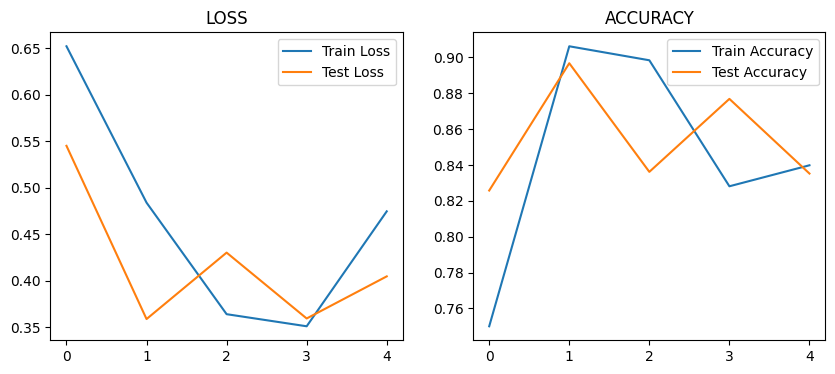

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(result_1["train_loss"], label="Train Loss")
plt.plot(result_1["test_loss"], label="Test Loss")
plt.title("LOSS")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result_1["train_acc"], label="Train Accuracy")
plt.plot(result_1["test_acc"], label="Test Accuracy")
plt.title("ACCURACY")
plt.legend()

# **=== 5. Make prediction ===**
1. Func: predict_and_plot()
2. Predict images from original dataset
3. Predict images from user's own images

## 5.1 Func: predict_and_plot()

In [35]:
from typing import List, Tuple
from PIL import Image

def predict_and_plot(model: torch.nn.Module,
                     image_path: str,
                     class_names: List[str],
                     image_size: Tuple[int, int] = (224, 224),
                     transform: torchvision.transforms = None,
                     device: torch.device = device):
    """ Image preprocess """
    # Open image
    image = Image.open(image_path)

    # Creata transform for image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    """ Predict """
    model.to(device)
    model.eval()

    with torch.inference_mode():
        transformed_image = image_transform(image).unsqueeze(dim = 0)

        logits = model(transformed_image.to(device))

    probs = torch.softmax(logits, dim = 1)
    labels = torch.argmax(probs, dim = 1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pridict: {class_names[labels]} | Probability: {probs.max():.2f}")
    plt.axis("off")

## 5.2 Images from original dataset

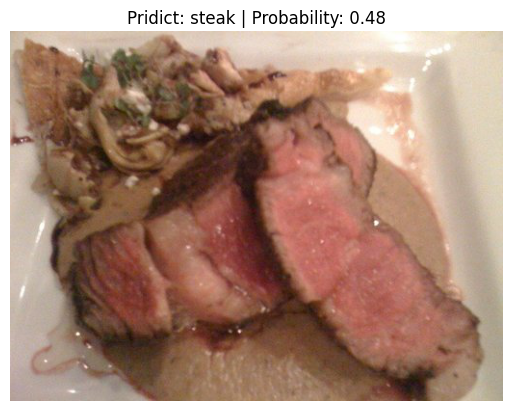

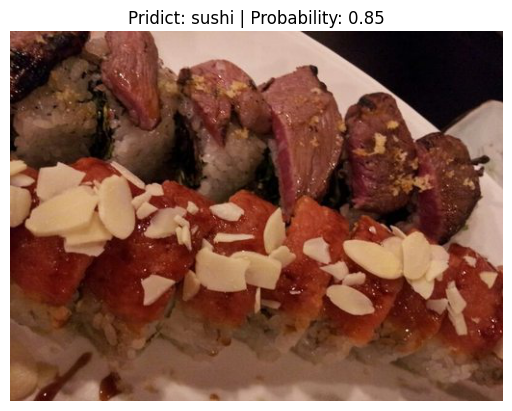

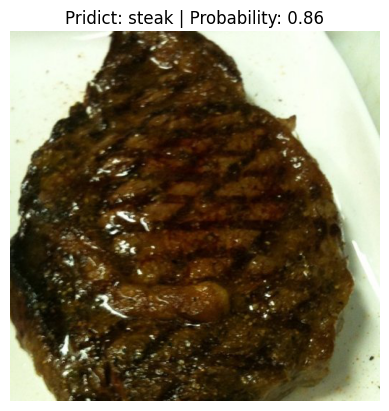

In [37]:
import glob
import random

image_unm = 3
class_names = ['pizza', 'steak', 'sushi']

image_path_list = list(Path(test_dir).glob("*/*.jpg"))
image_path_samples = random.sample(image_path_list, image_unm)

device = "cuda" if torch.cuda.is_available() else "cpu"

for sample in image_path_samples:
    predict_and_plot(model = model_1,
                     image_path = sample,
                     class_names = class_names,
                     image_size = (224, 224),
                     device = device)

## 5.3 Images from user's own images

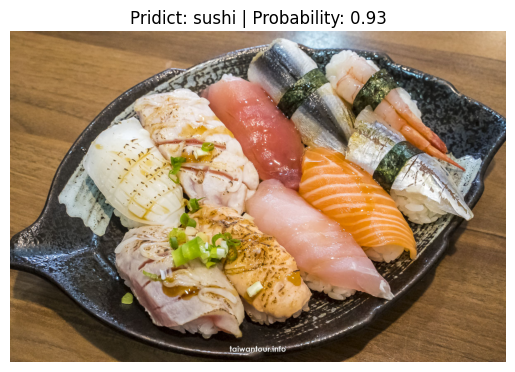

In [38]:
class_names = ['pizza', 'steak', 'sushi']

device = "cuda" if torch.cuda.is_available() else "cpu"

predict_and_plot(model = model_1,
                 image_path = "/content/sushi_0.jpg",
                 class_names = class_names,
                 device = device)